# TiiQU Academic Trustworthy Score :

#### The Purpose of this code is to extract and scrape information of an academic publisher from multiple sources to determine the transparency and trustworthyness score:
    - Check whether a publication house has a proper plagiarism policy and then assign a score of 0/1.
    - Check whether there are instances of retraction for a publication house and assign score of 0/1.
    - Check the percentage of open access journals a publication house has. 

- Developed by  Kinsuk Ghatak
- kinsuk.g@tiiqunetwork.onmicrosoft.com
- Last updated on: 20-03-2025

### General processflow : 

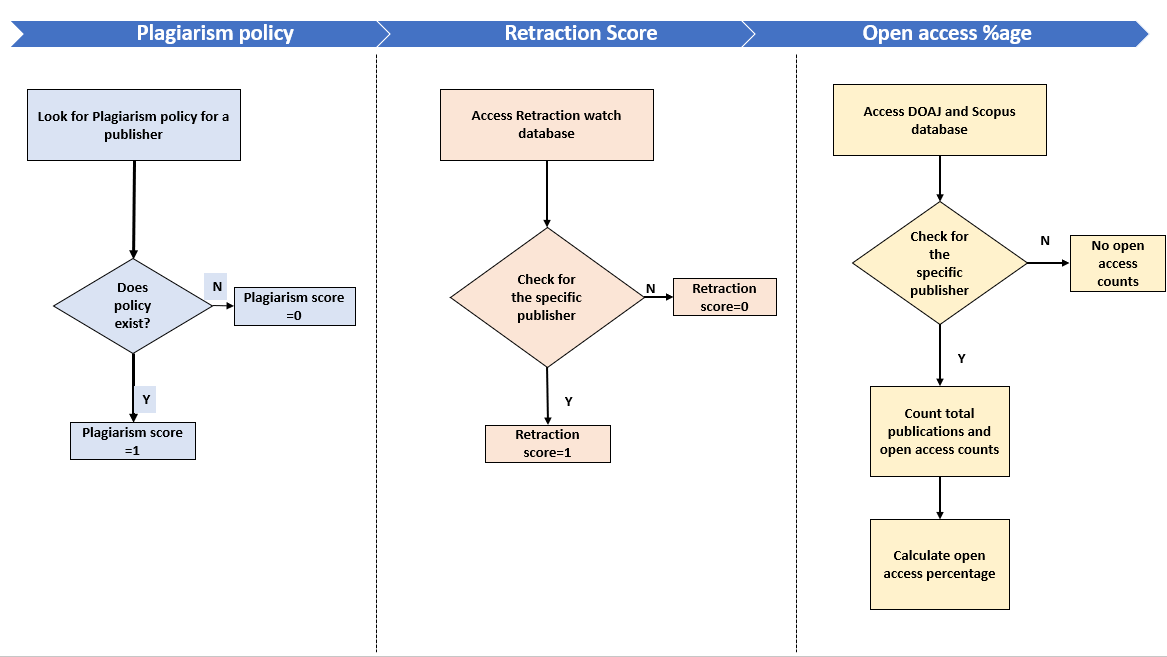

## Code running instructions: 

- The code needs to be run every month after 10th as the Scopus database gets updated after that.
- Please run Sections 1 to 4 first and then run Sec 5 that brings all the individual functions togerther under one umbrella

# Sec 1: Import libraries : 

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import time
from datetime import datetime

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
from rapidfuzz import process
from io import StringIO


import re
from googlesearch import search

import pandas as pd
from datetime import datetime
import calendar

from urllib.parse import quote

from tkinter import simpledialog, Tk

# Sec 2 : Scrape Plagiarism policy at Publisher level : 

### a. Fetch Publisher URL:

- Uses Google Search to find the official website of the given publisher.
- Encodes the query and searches for relevant URLs.
- Checks if the URL contains parts of the publisher's name and returns the first matching URL.

### b. Scrape for Plagiarism Policy:
- Sends a request to the publisher's website.
- Extracts and processes the page text.
- Searches for plagiarism-related keywords.
- Returns 1 if a plagiarism policy is found, otherwise 0.

### c. Handle Errors and Assumptions:
- If the request fails but the URL contains "plagiarism," assumes a policy exists.

### d. Main Function Execution:
- Calls the above functions in sequence.
- Returns 1 if a plagiarism policy is found, otherwise 0.

In [2]:


def fetch_publisher_url(publisher_name):
    """Search for the publisher website using Google Search."""
    # Wrap publisher name in quotes and URL encode the query
    query = f'{publisher_name} official site for editorial policies on plagiarism'
    encoded_query = quote(query)
    
    # Clean and split publisher name into parts (remove special chars and split by space)
    publisher_parts = re.findall(r'\w+', publisher_name.lower())

    for url in search(query, num_results=5):
        url_clean = url.lower().replace(" ", "")
        # Check if any part of publisher_name exists in URL
        if any(part in url_clean for part in publisher_parts):
            return url
    return None


    
def scrape_plagiarism_policy(url):
    """Scrape the publisher's website for plagiarism-related terms."""
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract all text from the website
        text = soup.get_text(separator=' ', strip=True).lower()

        # Keywords to search for plagiarism policy
        keywords = [
        "plagiarism policy", "anti-plagiarism", "plagiarism check", "paraphrasing", "copying",
        "ethical publishing", "publication ethics", "duplicate content", "plagiarism complaints",
        "plagiarism"
        ]
        # Check if any keyword exists in the text
        for keyword in keywords:
            if re.search(rf"\b{keyword}\b", text):
                return 1  # Plagiarism policy found
            # If scraping fails but URL contains 'plagiarism', assume policy exists
            if "plagiarism" in url.lower():
                print("Plagiarism-related URL found, assuming policy exists.")
                return 1
        return 0  # No plagiarism policy found
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the plagiarism policy URL {url}: {e}")
        # If request fails but URL contains 'plagiarism', assume policy exists
        if "plagiarism" in url.lower():
            print("Can't Access the plagirsm page but plagiarism-related URL found, assuming policy exists.")
            return 1
        return 0



def check_plagiarism_policy(publisher_name):
    """Main function to check plagiarism policy for a given publisher."""
    print(f"Checking plagiarism policy for publisher: {publisher_name}")
    
    # Step 1: Get publisher URL
    publisher_url = fetch_publisher_url(publisher_name)
    if not publisher_url:
        print("Publisher website could not be found.")
        return 0
    
    print(f"Publisher website found: {publisher_url}")
    
    # Step 2: Scrape for plagiarism policy
    score = scrape_plagiarism_policy(publisher_url)
    
    if score == 1:
        print("Plagiarism policy found.")
    else:
        print("Plagiarism policy not found.")
    
    return score




# Sec 3:  Retraction watch at publisher level:

### a. Fetch Retraction Data:
- Downloads the retraction_watch.csv file from GitLab and loads it into a Pandas DataFrame.
- If the dataset doesn't contain a "Publisher" column, it returns None.

### b. Find Matching Publishers:
- Extracts the list of unique publishers from the dataset.
- If an exact match for the given Publisher is found, it is selected directly.
- If no exact match is found, it uses fuzzy matching (via process.extract) to find similar names.
- Displays up to five similar publishers and asks the user to select the relevant ones.

### c. Calculate Retraction Score:
- Counts the number of retractions associated with the selected publisher(s).
- Assigns a retraction score of 1 if there is at least one retraction; otherwise, assigns 0.


### d. Fetch Metadata from GitLab:
- Scrapes the GitLab webpage for metadata related to retractions.
- Specifically looks for the phrase "Retraction Watch data for" in the webpage content.


### e. Return Results:
- Prints the retraction score and total retractions for the given publisher.
- Returns both values as a tuple: (retraction_score, total_retractions).








In [3]:

def fetch_retraction_data(Publisher):
    """Fetch the retraction_watch.csv file from GitLab and load it into a DataFrame."""
    raw_url = "https://gitlab.com/crossref/retraction-watch-data/-/raw/main/retraction_watch.csv"
    gitlab_url = "https://gitlab.com/crossref/retraction-watch-data/-/blob/main/retraction_watch.csv?ref_type=heads"

    try:
        # Read the CSV file directly from GitLab
        df = pd.read_csv(raw_url)
        print(f"Retraction Data loaded successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    # Ensure 'Publisher' column exists
    if 'Publisher' not in df.columns:
        print("'Publisher' field not found in the dataset.")
        return None

    # Get unique publisher names
    unique_publishers = df['Publisher'].dropna().unique()

    # Check if an exact match exists
    if Publisher in unique_publishers:
        selected_publishers = [Publisher]
        print(f"Exact match found: '{Publisher}'")
    else:
        # No exact match, use fuzzy matching
        matches = process.extract(Publisher, unique_publishers, limit=5, score_cutoff=75)

        if not matches:
            print(f"No close matches found for '{Publisher}'.")
            return None

        # Show similar publisher names
        print(f"No exact match found for '{Publisher}', but found similar publishers:")
        for i, (match, score, _) in enumerate(matches, start=1):
            print(f"{i}. {match} (Similarity: {score:.2f}%)")

        # Get user input for selection
        selected_indices = input("Enter the sl number(s) of the publishers to consider (comma-separated for multiple) : ")
        selected_indices = [int(i.strip()) - 1 for i in selected_indices.split(",") if i.strip().isdigit()]

        selected_publishers = [matches[i][0] for i in selected_indices if i < len(matches)]

    print(f"Considering the following publishers: {selected_publishers}")

    # Count retractions for selected publishers
    total_retractions = len(df[df['Publisher'].isin(selected_publishers)])

    # Assign retraction score
    retraction_score = 1 if total_retractions > 0 else 0

    ## Extract metadata from GitLab webpage
    try:
        response = requests.get(gitlab_url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        # Search for "Retraction Watch data for"
        target_text = None
        for line in soup.stripped_strings:
            if "Retraction Watch data for" in line:
                target_text = line
                break
        print(target_text)
    except Exception as e:
        print(f"An error occurred while fetching metadata: {e}")

    print(f"Retraction Score for {Publisher}: {retraction_score}")

    return retraction_score, total_retractions


# Sec 4: Open Access & Peer review information from DOAJ :


### a.  Fetch the DOAJ Dataset
- Retrieves the Directory of Open Access Journals (DOAJ) dataset from https://doaj.org/csv.
- Loads the CSV data into a Pandas DataFrame.
- If the request fails or the dataset is not accessible, it returns None.

### b.  Find Matching Publishers
- Checks if the "Publisher" column exists in the dataset.
- Extracts unique publisher names from the dataset.
- If an exact match for publisher_name is found, it selects it directly.
- If no exact match is found, fuzzy matching (process.extract) is used to find the top 5 closest matches.
- Displays the similar publisher names and asks the user to select the relevant ones.

### c. Count Relevant Records
- Filters the dataset for the selected publishers.
- Counts the total number of DOAJ records for these publishers.
- Counts records where both "peer" and "review" appear in the "Review process" column (indicating open peer review).

### d. Return the Count of Open Peer-Reviewed Journals
- Returns the number of journals from the selected publisher(s) that explicitly mention peer review in the "Review process" column.

In [4]:


def fetch_doaj_count(publisher_name): 
    csv_url = "https://doaj.org/csv"
    headers = {"User-Agent": "Mozilla/5.0"}

    try:
        response = requests.get(csv_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch CSV: {response.status_code}")
            return None
        df = pd.read_csv(StringIO(response.text))
        print(f"DOAJ Data loaded successfully.")
    except Exception as e:
        print(f"An error occurred while fetching DOAJ data: {e}")
        return None

    # Ensure 'Publisher' column exists
    if 'Publisher' not in df.columns:
        print("'Publisher' field not found in DOAJ dataset.")
        return None

    # Get unique publisher names
    unique_publishers = df['Publisher'].dropna().unique()

    # Check for an exact match
    if publisher_name in unique_publishers:
        selected_publishers = [publisher_name]
        print(f"Exact match found: '{publisher_name}' in DOAJ data base ")
    else:
        # Use fuzzy matching to find close publisher names
        matches = process.extract(publisher_name, unique_publishers, limit=5, score_cutoff=75)

        if not matches:
            print(f"No close matches found for '{publisher_name}'in DOAJ data base. ")
            return None

        # Show similar publisher names
        print(f"No exact match found for '{publisher_name}' in DOAJ data base, but found similar publishers:")
        for i, (match, score, _) in enumerate(matches, start=1):
            print(f"{i}. {match} (Similarity: {score:.2f}%)")

        # Get user input for selection
        selected_indices = input("Enter the Sl number(s) of the publishers to consider (comma-separated for multiple) : ")
        selected_indices = [int(i.strip()) - 1 for i in selected_indices.split(",") if i.strip().isdigit()]

        selected_publishers = [matches[i][0] for i in selected_indices if i < len(matches)]

    print(f"Considering the publishers for DOAJ: {selected_publishers}")

    # Filter the DataFrame for the selected publishers
    publisher_df = df[df['Publisher'].isin(selected_publishers)]

    # Count total DOAJ records for these publishers
    pub_doaj_cont = len(publisher_df)

    # Count records where both "peer" and "review" appear in the "Review process" column
    pub_doaj_open_peer_rvw_count = len(
        publisher_df[
            publisher_df["Review process"].str.contains(
                r"\bpeer\b.*\breview\b|\breview\b.*\bpeer\b", case=False, na=False, regex=True
            )
        ]
    )

    return pub_doaj_open_peer_rvw_count



# Sec 5: Extract Publisher information from Scopus

### a.  For this part we first need to log into scopus content page :  https://www.elsevier.com/products/scopus/content#4-titles-on-scopus

### b. Get the url of the file and share the url in the function
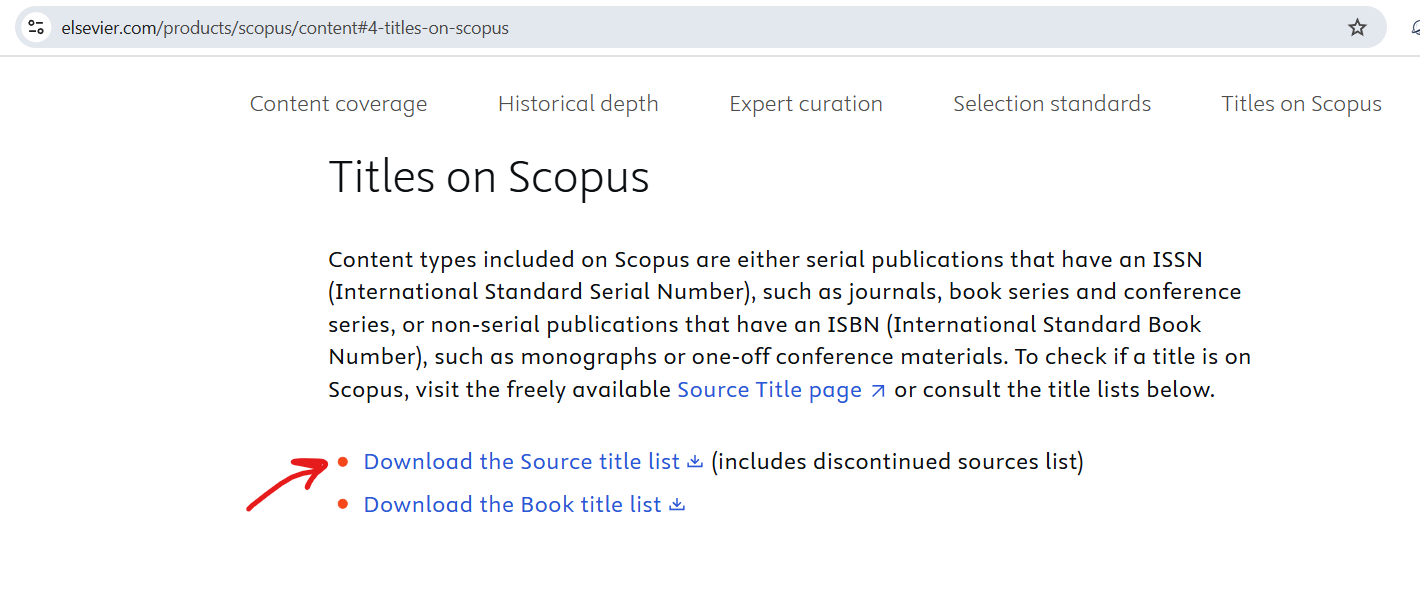

### c. Publisher Matching (Exact & Fuzzy):

- Checks if the input publisher_name exactly matches any publisher in the dataset.
- If not, uses fuzzy matching (via process.extract) to suggest close matches, allowing the user to manually select the relevant publishers.
### d. Filtering and Counting:

- Filters data to include only journals from the selected publisher(s), counts total journals, and counts the number of unique languages used across these journals (language diversification).

### e. The file only gets updated after10th of every month :
- We can run the final data extraction function below only after 10th every month.

In [5]:


def clean_subject_names(index_series):
    """Cleans subject names by removing numbers and newline characters."""
    return index_series.str.replace(r"\d+\s*\n*", "", regex=True).str.strip()

def extract_info_scopus(publisher_name,scopus_url):
    # Get the current system date
    current_date = datetime.now()

    # Compute the previous month and year (one-month lag)
    prev_month = current_date.month - 1 or 12  # If January, set to December (12)
    prev_year = current_date.year if current_date.month > 1 else current_date.year - 1

    # Get the full month name (e.g., "January", "December")
    prev_month_name = calendar.month_name[prev_month]
    

    # Construct the file name dynamically
    file_name = f"ext_list_{prev_month_name}_{prev_year}.xlsx"

    file_url=scopus_url
    
    # Construct the sheet name dynamically (e.g., "Scopus Sources Jan. 2025")
    sheet_name = f"Scopus Sources {prev_month_name[:3]}. {prev_year}"

    try:
        # Read the Excel file from the dynamically generated URL and sheet name
        df = pd.read_excel(file_url, sheet_name=sheet_name, engine="openpyxl")
        print(f"Successfully read data from sheet: {sheet_name}")
    except Exception as e:
        print(f"Error reading the file: {e}")
        return None

    # Ensure the required column exists
    if 'Publisher Imprints Grouped to Main Publisher' not in df.columns:
        print("'Publisher Imprints Grouped to Main Publisher' field not found in Scopus dataset.")
        return None

    # Get unique publisher names
    unique_publishers = df['Publisher Imprints Grouped to Main Publisher'].dropna().unique()

    # Check for an exact match
    if publisher_name in unique_publishers:
        selected_publishers = [publisher_name]
        print(f"Exact match found: '{publisher_name}' in Scopus")
    else:
        # Use fuzzy matching to find close publisher names
        matches = process.extract(publisher_name, unique_publishers, limit=5, score_cutoff=75)

        if not matches:
            print(f"No close matches found for '{publisher_name}' in Scopus.")
            return None

        # Show similar publisher names
        print(f"No exact match found for '{publisher_name}', but found similar publishers from Scopus:")
        for i, (match, score, _) in enumerate(matches, start=1):
            print(f"{i}. {match} (Similarity: {score:.2f}%)")

        # Get user input for selection
        selected_indices = input("Enter the sl number of the publishers to consider (comma-separated for multiple) : ")
        selected_indices = [int(i.strip()) - 1 for i in selected_indices.split(",") if i.strip().isdigit()]

        selected_publishers = [matches[i][0] for i in selected_indices if i < len(matches)]

    print(f"Considering the following publishers: {selected_publishers}")

    # Filter the DataFrame for the selected publishers
    df_publisher = df[(df['Source Type'] == 'Journal') & (df['Publisher Imprints Grouped to Main Publisher'].isin(selected_publishers))]

    # Language Diversification: Count unique languages
    unique_langs = len(pd.unique(df_publisher['Article Language in Source (Three-Letter ISO Language Codes)'].dropna()))

    # Total number of journals
    count_publishers = len(df_publisher)

    ## Subject Diversification: 
    # Select subject columns (25 to 52)
    subject_df = df_publisher.iloc[:, 25:52]

    # Count non-null values per subject
    subject_counts = subject_df.notna().sum()

    # Remove subjects with zero count
    subject_counts = subject_counts[subject_counts > 0]

    # Clean subject names
    subject_counts.index = clean_subject_names(subject_counts.index.to_series())

    # Calculate percentages
    total_journals = subject_counts.sum()
    subject_percentages = (subject_counts / total_journals * 100).round(2)

    # Combine into a DataFrame
    subject_distribution = pd.DataFrame({
        "Journal Count": subject_counts,
        "Percentage (%)": subject_percentages
    })

    return count_publishers, unique_langs, subject_distribution


## Sec 6: Bring everything together: 

### a. get_scopus_url() function:
- Checks if the global variable scopus_url is already filled.
- If not filled, a Tkinter pop-up dialog box appears asking for user input.
- Once provided, it's stored permanently in that session in scopus_url and reused in subsequent calls.

### b. pub_score(publisher_name) fnction:
- Brings all the above functions together
- A pop up will appear. The user needs to give the scopus url's input there.
- Following this the pub_scorE() function will check pkagiarism policy, Retraction score Followed by DOAJ open access and finally Scopus for the total counts of jhournals 

In [6]:

# Initialize global variable to store Scopus URL
scopus_url = None

def get_scopus_url():
    global scopus_url
    if not scopus_url:
        # Initialize Tkinter root window
        root = Tk()
        root.withdraw()  # Hide the main window
        
        # Prompt user for input
        scopus_url = simpledialog.askstring("Input", "Please enter the Scopus URL:")
        
        if not scopus_url:
            print("No URL provided. Exiting...")
            exit()
            
        root.destroy()  # Close the window
        
    return scopus_url



def pub_score(publisher_name):
    
    # Get scopus_url (once per session)
    scopus_url_input = get_scopus_url()
    
    print("Step 1 : Checking Plagiarism policy : ")
    plag_policy_score = check_plagiarism_policy(publisher_name)
    print("Step 2 :Checking Retraction Score : ")
    retraction_score = fetch_retraction_data(publisher_name)[0]
    print("Step 3 :Checking DOAJ Open Source Counts: ")
    pub_doaj_open_peer_rvw_count = fetch_doaj_count(publisher_name)
    print("Step 4 :Checking Total publication counts from Scopus : ")
    total_publication_scopus = extract_info_scopus(publisher_name,scopus_url)[0]
    
    # Prevent division by zero
    if total_publication_scopus == 0:
        open_access_percentage = 0  # or assign None if needed
    else:
        open_access_percentage = pub_doaj_open_peer_rvw_count / total_publication_scopus
    
    df_pub_Score = pd.DataFrame([{
        "Publisher Name": publisher_name,
        "Plagiarism Policy Score": plag_policy_score,
        "Retraction Score": retraction_score,
        "DOAJ Open Peer Review Count": pub_doaj_open_peer_rvw_count,
        "Total Count of Publications from Scopus": total_publication_scopus,
        "%age of Open Access": open_access_percentage
    }])
    
    return df_pub_Score


In [7]:
pub_score("Elsevier")

Step 1 : Checking Plagiarism policy : 
Checking plagiarism policy for publisher: Elsevier
Publisher website found: https://www.elsevier.com/en-gb/editor/perk/plagiarism-complaints
Plagiarism-related URL found, assuming policy exists.
Plagiarism policy found.
Step 2 :Checking Retraction Score : 
Retraction Data loaded successfully.
Exact match found: 'Elsevier'
Considering the following publishers: ['Elsevier']
Retraction Watch data for 2025-03-19
Retraction Score for Elsevier: 1
Step 3 :Checking DOAJ Open Source Counts: 
DOAJ Data loaded successfully.
Exact match found: 'Elsevier' in DOAJ data base 
Considering the publishers for DOAJ: ['Elsevier']
Step 4 :Checking Total publication counts from Scopus : 
Successfully read data from sheet: Scopus Sources Feb. 2025
Exact match found: 'Elsevier' in Scopus
Considering the following publishers: ['Elsevier']


,Publisher Name,Plagiarism Policy Score,Retraction Score,DOAJ Open Peer Review Count,Total Count of Publications from Scopus,%age of Open Access
0,Elsevier,1,1,816,3843,0.212334


In [8]:
pub_score ("Springer Nature")

Step 1 : Checking Plagiarism policy : 
Checking plagiarism policy for publisher: Springer Nature
Publisher website found: https://www.springernature.com/gp/policies/editorial-policies
Plagiarism policy found.
Step 2 :Checking Retraction Score : 
Retraction Data loaded successfully.
No exact match found for 'Springer Nature', but found similar publishers:
1. Springer (Similarity: 90.00%)
2. Cureus (Part of Springer Nature as of December 2022) (Similarity: 90.00%)
3. Springer - Nature Publishing Group (Similarity: 85.50%)
4. Springer - Biomed Central (BMC) (Similarity: 85.50%)
5. Nature Publishing Group (Similarity: 85.50%)
Enter the sl number(s) of the publishers to consider (comma-separated for multiple) : 3
Considering the following publishers: ['Springer - Nature Publishing Group']
Retraction Watch data for 2025-03-19
Retraction Score for Springer Nature: 1
Step 3 :Checking DOAJ Open Source Counts: 
DOAJ Data loaded successfully.
Exact match found: 'Springer Nature' in DOAJ data base

,Publisher Name,Plagiarism Policy Score,Retraction Score,DOAJ Open Peer Review Count,Total Count of Publications from Scopus,%age of Open Access
0,Springer Nature,1,1,7,3224,0.002171


In [9]:
pub_score ("Wiley")

Step 1 : Checking Plagiarism policy : 
Checking plagiarism policy for publisher: Wiley
Publisher website found: https://www.wiley.com/en-us/network/publishing/research-publishing/editors/plagiarism-and-libel
Error fetching the plagiarism policy URL https://www.wiley.com/en-us/network/publishing/research-publishing/editors/plagiarism-and-libel: 403 Client Error: Forbidden for url: https://www.wiley.com/en-us/network/publishing/research-publishing/editors/plagiarism-and-libel
Can't Access the plagirsm page but plagiarism-related URL found, assuming policy exists.
Plagiarism policy found.
Step 2 :Checking Retraction Score : 
Retraction Data loaded successfully.
Exact match found: 'Wiley'
Considering the following publishers: ['Wiley']
Retraction Watch data for 2025-03-19
Retraction Score for Wiley: 1
Step 3 :Checking DOAJ Open Source Counts: 
DOAJ Data loaded successfully.
Exact match found: 'Wiley' in DOAJ data base 
Considering the publishers for DOAJ: ['Wiley']
Step 4 :Checking Total p

,Publisher Name,Plagiarism Policy Score,Retraction Score,DOAJ Open Peer Review Count,Total Count of Publications from Scopus,%age of Open Access
0,Wiley,1,1,450,2272,0.198063


In [14]:
pub_score ("Taylor & Francis")

Step 1 : Checking Plagiarism policy : 
Checking plagiarism policy for publisher: Taylor & Francis
Publisher website found: https://authorservices.taylorandfrancis.com/editorial-policies/plagiarism/
Error fetching URL https://authorservices.taylorandfrancis.com/editorial-policies/plagiarism/: 403 Client Error: Forbidden for url: https://authorservices.taylorandfrancis.com/editorial-policies/plagiarism/
Plagiarism policy not found.
Step 2 :Checking Retraction Score : 
Retraction Data loaded successfully.
No exact match found for 'Taylor & Francis', but found similar publishers:
1. Taylor and Francis (Similarity: 88.67%)
2. Taylor and Francis - Dove Press (Similarity: 85.50%)
3. Wolters Kluwer - Lippincott Williams & Wilkins (Similarity: 85.50%)
4. Academic Publishing & Translation (Similarity: 85.50%)
5. Korean Society of Occupational & Environmental Medicine (Similarity: 85.50%)
Enter the sl number(s) of the publishers to consider (comma-separated for multiple) : 1
Considering the follo

,Publisher Name,Plagiarism Policy Score,Retraction Score,DOAJ Open Peer Review Count,Total Count of Publications from Scopus,%age of Open Access
0,Taylor & Francis,0,1,6,3103,0.001934
